In [1]:
#Run this to troubleshoot some problem with the cairo library (happens in macos)
#Also, need to add to settings.json the following:
#"terminal.integrated.env.osx": {
#     "DYLD_LIBRARY_PATH": "/opt/homebrew/opt/cairo/lib:${env:DYLD_LIBRARY_PATH}"
# },

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/cairo/lib:$DYLD_LIBRARY_PATH'


In [2]:
import sys
sys.path.append('/Users/evatakou/noise_est')
from color_code_stim import *

from noise_est_funcs_for_color_code import *
from sims.color_code_bare_ancilla.utilities_for_color_code import *
from sims.color_code_bare_ancilla.numerical_equations_for_color_code import *
from equations_for_d_3 import *

import matplotlib.pyplot as plt 


from construct_dem import *
from defects_matrix_construction import *
from utilities_for_color_code import *



In [3]:
d          = 3
num_rounds = 1


p_circuit  = 1e-3
obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
circuit    = obj.circuit
nodes      =  collect_color_of_nodes(obj)

num_ancilla   = len(obj.qubit_groups['anc'])
Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)



In [4]:
dems_stim                     = {}


for color in ["r", "g", "b"]: 
    dem1,dem2        = obj.get_decomposed_dems(color)
    dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel
    

In [5]:
dets_Z,dets_X = get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds)


In [6]:
num_shots = 2*10**7
defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS = get_defects(circuit,num_rounds,num_shots,obj)

obs_flips = get_observable_flips(data_qubit_samples,d)

min_bound = 1e-12
max_bound = 0.6              
method    = "least_squares"  

vi_mean_Z   = avg_vi(defects_matrix_Z)
vivj_mean_Z = avg_vivj(defects_matrix_Z.data)


In [7]:
p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
detector_type  = "Z"
vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

if len(defects_matrix_X)>0: #non-empty

    vi_mean_X      = avg_vi(defects_matrix_X) 
    vivj_mean_X    = avg_vivj(defects_matrix_X) 
    p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds) 
    detector_type  = "X" 
    vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type) 
    sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X) 


In [8]:

#Get the edges for the Z_DEM
sols_for_defect_type           = sols_for_Z    
vi_mean                        = vi_mean_Z  
vivj_mean                      = vivj_mean_Z     
stims_DEM                      = Z_DEM    
defects_type                   = "Z" 
pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type) 



In [9]:
def append_L0_to_edges(Z_DEM,pij_time,pij_bulk,pij_bd):

    pij_time_new = {}
    pij_bulk_new = {}
    pij_bd_new   = {}

    for instruction in Z_DEM:

        if instruction.type=="error":

            targets   = instruction.targets_copy()
            dets      = []
            dets_w_L0 = []

            for target in targets:
                if target.is_relative_detector_id():
                    id = target.val 
                    dets.append("D"+str(id))
                    dets_w_L0.append("D"+str(id))
                else:
                    dets_w_L0.append("L0")
            
            if tuple(dets) in pij_bulk.keys():
                pij_bulk_new[tuple(dets_w_L0)] = pij_bulk[tuple(dets)]
            
            if tuple(dets) in pij_time.keys():
                pij_time_new[tuple(dets_w_L0)] = pij_time[tuple(dets)]
            
           
            if len(dets)==1:
                    
                pij_bd_new[tuple(dets_w_L0)] = pij_bd[dets[0]]


    #Now put the new boundaries, by keeping only those with definite values:
            
    return pij_time_new,pij_bulk_new,pij_bd_new

pij_time,pij_bulk,pij_bd = append_L0_to_edges(Z_DEM,pij_time,pij_bulk,pij_bd)



In [ ]:
max_order         = 2
sols,pij_bd_final = solve_boundary_equations_with_least_squares(pij_time,pij_bulk,p3,pij_bd,
                                                                                       defects_matrix_Z,obj,num_rounds,
                                                                                       obs_flips,max_order,Z_DEM,
                                                                                       defects_type="Z")


In [ ]:
def update_bd_edges(pij_bd,pij_bd_final):

    for key in pij_bd_final.keys():

        pij_bd[key]=pij_bd_final[key]

    return pij_bd
    
pij_bd = update_bd_edges(pij_bd,pij_bd_final)    



In [ ]:
#Now construct the new_Z_DEM

def construct_Z_DEM_final(pij_bd_final,p3,pij_time_new,pij_bulk_new):

    my_Z_DEM = stim.DetectorErrorModel()

    for key in p3.keys():

        targets = [stim.target_relative_detector_id(int(det[1:])) for det in key]
        my_Z_DEM.append("error",p3[key],targets)


    for key in pij_time_new.keys():

        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0]=="D" \
                   else stim.target_logical_observable_id(0) for det in key]

        my_Z_DEM.append("error",pij_time_new[key],targets)


    for key in pij_bulk_new.keys():

        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0]=="D" \
                   else stim.target_logical_observable_id(0) for det in key]        

        my_Z_DEM.append("error",pij_bulk_new[key],targets)


    for key in pij_bd_final.keys():

        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0]=="D" \
                   else stim.target_logical_observable_id(0) for det in key]          
        
        prob = pij_bd_final[key]
        my_Z_DEM.append("error",prob,targets)
            

    return my_Z_DEM

my_Z_DEM = construct_Z_DEM_final(pij_bd,p3,pij_time,pij_bulk)

bd_stim: {('D0', 'L0'): 0.004582241746532972, ('D1',): 0.0011992888888887063, ('D1', 'L0'): 0.003258480791344033, ('D2',): 0.001931182734310662, ('D2', 'L0'): 0.000533333333333148, ('D3', 'L0'): 0.004053055241335569, ('D4', 'L0'): 0.003523480286975192, ('D5',): 0.0048465350479526634, ('D5', 'L0'): 0.000533333333333148}
bd_mine: {('D0', 'L0'): 0.004574833271246748, ('D1',): 0.0011858303466348026, ('D1', 'L0'): 0.003265739640359381, ('D2',): 0.0019277254460841893, ('D2', 'L0'): 0.0005389753487131776, ('D3', 'L0'): 0.0040667247168855725, ('D4', 'L0'): 0.0035269774832323852, ('D5',): 0.004888128923461288, ('D5', 'L0'): 0.000533060354329347}


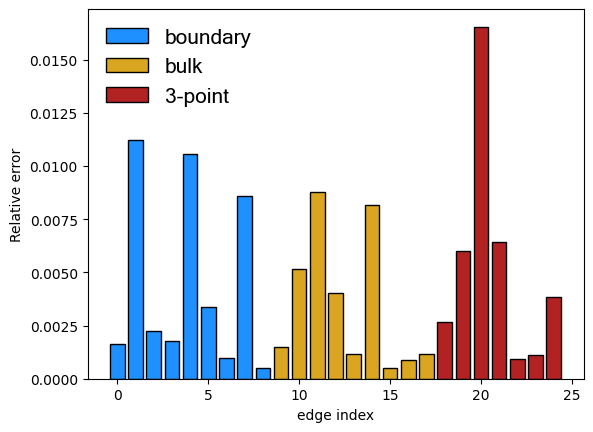

In [ ]:
#Compare the edges of the 2 DEMS
import matplotlib
from matplotlib import pyplot as plt 

def relative_error_of_edges(stims_DEM,my_DEM):

    errors_in_stims_DEM = {}
    for instruction in stims_DEM:
        if instruction.type=="error":
            
            targets = instruction.targets_copy()
            prob    = instruction.args_copy()[0]
            dets    = []

            dets = [f"D{target.val}" if target.is_relative_detector_id() else\
                    "L0" for target in targets ]


            errors_in_stims_DEM[tuple(dets)]=prob

    errors_in_my_DEM = {}

    for instruction in my_DEM:
        if instruction.type=="error":
            
            targets = instruction.targets_copy()
            prob    = instruction.args_copy()[0]

            dets = [f"D{target.val}" if target.is_relative_detector_id() else\
                    "L0" for target in targets ]            

            errors_in_my_DEM[tuple(dets)]=prob

    rel_error_p3 = {}
    rel_error_p2 = {}
    rel_error_p1 = {}

    bd_stim = {}
    bd_mine = {}
    for key in errors_in_stims_DEM.keys():

        p_true  = errors_in_stims_DEM[key]
        p_est   = errors_in_my_DEM[key]

        if len(key)==3:
            if key[1]=="L0":
                rel_error_p2[key] = abs(p_true-p_est)/p_true 
            else:
                rel_error_p3[key] = abs(p_true-p_est)/p_true 
        if len(key)==2:
            
            if key[1]=="L0":
                
                rel_error_p1[key] = abs(p_true-p_est)/p_true 
                bd_stim[key] = p_true 
                bd_mine[key] = p_est

            else:
                rel_error_p2[key] = abs(p_true-p_est)/p_true 


        if len(key)==1:
            rel_error_p1[key] = abs(p_true-p_est)/p_true
            bd_stim[key] = p_true 
            bd_mine[key] = p_est


    return rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine

rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine = relative_error_of_edges(Z_DEM,my_Z_DEM)

fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    


x1 = np.arange(len(rel_error_p1.keys()))
x2 = np.arange(x1[-1]+1,len(rel_error_p2.keys())+x1[-1]+1)
x3 = np.arange(x2[-1]+1,len(rel_error_p3.keys())+x2[-1]+1)

plt.bar(x=x1,height=list(rel_error_p1.values()),
        facecolor='dodgerblue',edgecolor='black')
plt.bar(x=x2,height=list(rel_error_p2.values()),
        facecolor='goldenrod',edgecolor='black')
plt.bar(x=x3,height=list(rel_error_p3.values()),
        facecolor='firebrick',edgecolor='black')

        
plt.legend(['boundary','bulk','3-point'],
           frameon=False,shadow=True,fontsize=15,loc='best')
plt.xlabel('edge index')
plt.ylabel('Relative error')

# fig.savefig('bar_plot_d_3_r_1_error_1e_minus_3_N_est_2_10_7_Z_DEM_Edges.svg', format='svg', dpi=1500,bbox_inches='tight')

print("bd_stim:",bd_stim)
print("bd_mine:",bd_mine)